# LightGBM Predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
''
import gc
import math

## Load and downcast data

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    if df.loc[:, 'device'].dtype != 'int16':
        df.loc[:, 'device'] = df.loc[:, 'device'].astype(np.int16)
    if df.loc[:, 'os'].dtype != 'int16':
        df.loc[:, 'os'] = df.loc[:, 'os'].astype(np.int16)
    if df.loc[:, 'channel'].dtype != 'int16':
        df.loc[:, 'channel'] = df.loc[:, 'channel'].astype(np.int16)
    if 'is_attributed' in df.columns:
        df.loc[:, 'is_attributed'] = df.loc[:, 'is_attributed'].astype(np.int8)
    
    if 'day' in df.columns and df.loc[:, 'day'].dtype != 'int8':
        df.loc[:, 'day'] = df.loc[:, 'day'].astype(np.int8)
    
    return df

In [3]:
def to_drop(df):
    df.drop([c for c in df if 'target_mean' in c or 'nextClick' in c or 'timeframe' in c],
            axis=1, inplace=True)
    return df

In [4]:
b_include_test = True
n_chunks = 10

with pd.HDFStore('instance-1/home/klauke_peter/store_enc_chunks.h5',  mode='r') as store:
    for n in range(n_chunks):
        df_train_chunk = store.select('df_train_chunk{}'.format(n))
        df_train_chunk = to_drop(df_train_chunk)
        print('Loaded df_train_chunk{}'.format(n))
        
        df_train_chunk = downcast_dtypes(df_train_chunk)
        if n == 0:
            df_train = df_train_chunk
        else:
            df_train = pd.concat([df_train, df_train_chunk])
        del df_train_chunk
        gc.collect()
        
    print('Finished df_train, shape:', df_train.shape)
    
    df_valid =  downcast_dtypes(store.select('df_valid'))
    df_valid = to_drop(df_valid)
    print('Loaded df_valid')
    df_valid = downcast_dtypes(df_valid)
    print('Finished df_valid, shape:', df_valid.shape)
    
    if b_include_test:
        df_test =  downcast_dtypes(store.select('df_test'))
        df_test = to_drop(df_test)
        print('Loaded df_test')
        df_test = downcast_dtypes(df_test)
        print('Finished df_test, shape', df_test.shape)

Loaded df_train_chunk0
Loaded df_train_chunk1
Loaded df_train_chunk2
Loaded df_train_chunk3
Loaded df_train_chunk4
Loaded df_train_chunk5
Loaded df_train_chunk6
Loaded df_train_chunk7
Loaded df_train_chunk8
Loaded df_train_chunk9
Finished df_train, shape: (179903890, 36)
Loaded df_valid
Finished df_valid, shape: (5000000, 36)
Loaded df_test
Finished df_test, shape (18790469, 36)


## Time-based split between training and validation

Create a time-based split between training and validation for proper validation during feature selection and hyperparameter tuning. If there would've been time left in the competition the complete training data (including validation data) should've been used for the final submission.

In [5]:
split_date = pd.Timestamp(year=2017, month=11, day=9, hour=5) # hour=4

df_train = df_train.loc[df_train.click_time < split_date, :]

In [6]:
df_valid = df_valid.loc[ ((df_valid.minute_of_day > 295) & (df_valid.minute_of_day < 365))
                       | ((df_valid.minute_of_day > 535) & (df_valid.minute_of_day < 665))
                       | ((df_valid.minute_of_day > 770) & (df_valid.minute_of_day < 905))]

gc.collect()

print('train shape: ', df_train.shape)
print('valid shape: ', df_valid.shape)

train shape:  (148239045, 36)
valid shape:  (2327952, 36)


/home/klauke_peter/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/klauke_peter/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


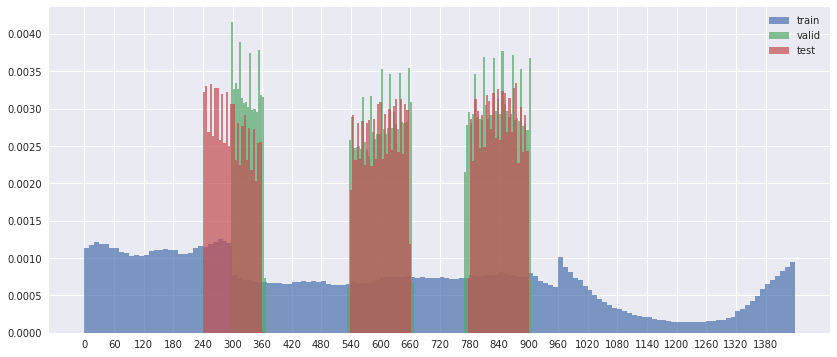

In [7]:
plt.figure(figsize=(14, 6))

plt.hist(df_train.click_time.dt.hour*60 + df_train.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='train')
plt.hist(df_valid.click_time.dt.hour*60 + df_valid.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='valid')
if b_include_test:
    plt.hist(df_test.click_time.dt.hour*60 + df_test.click_time.dt.minute, bins=(24*60)//10, normed=True, alpha=0.7, label='test')

plt.legend()
plt.xticks(range(0, 60*24, 60))

plt.show()

## Modelling

In [6]:
from sklearn.metrics import roc_auc_score
import lightgbm

lgb_features_cat = ['app', 'os', 'channel', 'device', 'hour', 'day']

lgb_features = lgb_features_cat
lgb_features += [
                    'next_click', 'next_click_shift',
                    'app_nunique_gby_ip', 'app_nunique_gby_ip_device_os',
                    'channel_count_gby_ip_app', 'channel_count_gby_ip_app_os',
                    'channel_count_gby_ip_day_hour', 'channel_nunique_gby_app',
                    'channel_nunique_gby_ip', 'day_var_gby_ip_app_channel', 'device_nunique_gby_ip',
                    'hour_mean_gby_ip_app_channel', 'hour_nunique_gby_ip_day',
                    'hour_var_gby_ip_app_os', 'hour_var_gby_ip_day_channel',
                    'os_count_gby_ip', 'os_nunique_gby_ip_app',
                    'app_cumcount_gby_ip_device_os', 'os_cumcount_gby_ip'
                ]

In [ ]:
df_train = df_train.loc[:, lgb_features+['is_attributed']]
gc.collect()

In [ ]:
from sklearn.metrics import roc_auc_score
import lightgbm

n_trees = 4000

lgb_train_set = lightgbm.Dataset(df_train.loc[:, lgb_features], label=df_train.loc[:, 'is_attributed'])
lgb_valid_set = lightgbm.Dataset(df_valid.loc[:, lgb_features], label=df_valid.loc[:, 'is_attributed'])

seed = 4

params_lgb = {'objective': 'binary', 'metric': 'AUC', 'boosting': 'gbdt', 'learning_rate': 0.2,
              'verbose': 0, 'num_leaves': 15, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'bagging_seed': seed,
              'feature_fraction': 0.9, 'feature_fraction_seed': seed, 'max_bin': 32,
              'min_data_in_leaf': 50, 'seed': seed, 'lambda_l1': 0, 'lambda_l2': 0,
              'scale_pos_weight': 200, 'two_round': True, 'max_depth': 3, 'min_sum_hessian_in_leaf': 500}

lgb = lightgbm.train(params_lgb, 
                     train_set=lgb_train_set,
                     num_boost_round=n_trees,
                     valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'valid'],
                     fobj=None, feval=None, init_model=None,
                     feature_name='auto', categorical_feature='auto', 
                     early_stopping_rounds=100, evals_result=None, verbose_eval=10, learning_rates=None, 
                     keep_training_booster=False, callbacks=None)

del lgb_train_set, lgb_valid_set
gc.collect()

In [ ]:
import pickle
 
pickle.dump(lgb,  open( 'lgb_le0.2_allchunks_{}.pkl'.format(seed), 'wb' ) )

In [ ]:
fig = plt.figure(figsize=(10, 6))

feature_importance = lgb.feature_importance()
sorted_idx = np.argsort(feature_importance)

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(lgb_features)[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.draw()
plt.show()

In [ ]:
preds_test = lgb.predict(df_test.loc[:, lgb_features])

## Save predictions for ensembling

In [ ]:
file_suffix = seed
assert file_suffix != '', "What is my name?"

df_test.loc[:, 'prediction']  = preds_test
df_test.loc[:, 'prediction'] = df_test.loc[:, 'prediction'].astype(np.float32)
df_test.loc[:, ['prediction']].to_csv('predictions_test_{}.csv'.format(file_suffix))

print('Valid AUC: {:0.5f}'.format(roc_auc_score(df_valid.loc[:, 'is_attributed'], preds_valid)))
df_valid.loc[:, 'prediction'] = preds_valid
df_valid.loc[:, 'prediction'] = df_valid.loc[:, 'prediction'].astype(np.float32)
df_valid.loc[:, ['prediction']].to_csv('predictions_valid_{}.csv'.format(file_suffix))

# Submit single model

In [19]:
df_submission = pd.read_csv('instance-1/home/klauke_peter/.kaggle/competitions/talkingdata-adtracking-fraud-detection/sample_submission.csv.zip')
df_submission.head(n=2)

,click_id,is_attributed
0,0,0
1,1,0


In [20]:
df_submission.loc[:, 'is_attributed'] = preds_test
df_submission.to_csv('submission.csv.gz', index = False, compression = 'gzip', float_format='%.8f')

df_submission.head()

,click_id,is_attributed
0,0,0.077275
1,1,0.017600
2,2,0.001230
3,3,0.031964
4,4,0.019336


In [21]:
import os

subname = 'lgb' + str(seed)
os.system('kaggle competitions submit -c talkingdata-adtracking-fraud-detection -f submission.csv.gz -m "{}"'.format(subname))

0